In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from ipynb.fs.full.utilities import *

In [30]:
class PokemonNet:
    
    @staticmethod
    def build_type1_branch(inputs, numType1, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType1)(x)
        x = Activation(finalAct, name="type1_classification")(x)
        
        return x
        
    @staticmethod
    def build_type2_branch(inputs, numType2, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType2)(x)
        x = Activation(finalAct, name="type2_classification")(x)
        
        return x
    
    @staticmethod
    def build_model(input_shape, numType1, numType2, finalAct="sigmoid"):
        
        inputs = Input(shape=input_shape)

        """
        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        """
        
        # Constructing type 1 and type 2 heads.
        type1_branch = PokemonNet.build_type1_branch(inputs, numType1, finalAct)
        type2_branch = PokemonNet.build_type2_branch(inputs, numType2, finalAct)
        
        # Building the model
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[type1_branch, type2_branch],
            name="pokemonnet"
                     )
        
        return model    
    
    @staticmethod
    def net_generator(generator, data, label1, label2, batch_s):
        gen1 = generator.flow(data, label1, batch_size=batch_s)
        gen2 = generator.flow(data, label2, batch_size=batch_s)
        while True:
            X1 = gen1.next()
            X2 = gen2.next()
            yield X1[0], [X1[1], X2[1]] 
    
        
        
        

In [46]:
EPOCHS = 50
BATCH_SIZE = 28
INIT_LR = 1e-3
IMG_DIMS = [150, 150]
ACTIVATION = 'sigmoid'


# Extracting images
data = load_images('images\images', IMG_DIMS)

# Values between [0, 1]
data = np.array(data, dtype='float')/255.0
#plt.imshow(data[0,:,:,:])

data_layer3 = np.load('features/train.npy')


# Binarize sets of labels
type1LB = LabelBinarizer()
type2LB = LabelBinarizer()
type1Labels = type1LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type1'))
type2Labels = type2LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type2'))

#ptypeLabels = label_dataset('Bug', 'pokemon_2.csv')
#print(ptypeLabels)

# Split data into training and validation
split = train_test_split(data_layer3, type1Labels, type2Labels, test_size=0.2)
(trainX, testX, trainType1Y, testType1Y, trainType2Y, testType2Y) = split

"""
# build the VGG16 network, leaving off the top classifier layer
# so we just get the features as output
print('Building VGG16...')
inputs = Input(shape=(IMG_DIMS[0], IMG_DIMS[1], 3))
base_model = VGG16(weights='imagenet', include_top=False,
        input_tensor=inputs)

# Save training features
datagen = ImageDataGenerator()
generator = datagen.flow(
    trainX,
    batch_size=BATCH_SIZE,
    shuffle=False)

print('Saving bottleneck features (train)...')
bottleneck_features_train = base_model.predict(
    generator, trainX.shape[0] // BATCH_SIZE)
np.save('features/train.npy', bottleneck_features_train)

# Save validation features
generator = datagen.flow(
    testX,
    batch_size=BATCH_SIZE,
    shuffle=False)

print('Saving bottleneck features (validation)...')
bottleneck_features_validation = base_model.predict(
    generator, testX.shape[0] // BATCH_SIZE)
np.save('features/validation.npy',
        bottleneck_features_validation)
"""

# defining dictionary with respective losses.
losses = {
    "type1_classification": "categorical_crossentropy",
    "type2_classification": "categorical_crossentropy",
}

# Creating model
model = PokemonNet.build_model(data_layer3.shape[1:], 
                               numType1=len(type1LB.classes_),
                               numType2=len(type2LB.classes_),
                               finalAct= ACTIVATION)

model.compile(optimizer='adam', loss=losses, metrics=["accuracy"])

# Displaying model summary
model.summary()

# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

"""
# train the network to perform multi-output classification
H = model.fit(x=trainX, 
        y={"type1_classification": trainType1Y, "type2_classification": trainType2Y},
        validation_data=(testX, 
            {"type1_classification": testType1Y, "type2_classification": testType2Y}),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)
"""

# train the network to perform multi-output classification
H = model.fit(trainX, y={ "type1_classification": trainType1Y, "type2_classification": trainType2Y},
        validation_data= (testX, {"type1_classification": testType1Y, "type2_classification": testType2Y}),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)

Building model...
Model: "pokemonnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 37, 37, 256) 0                                            
__________________________________________________________________________________________________
flatten_24 (Flatten)            (None, 350464)       0           input_33[0][0]                   
__________________________________________________________________________________________________
flatten_25 (Flatten)            (None, 350464)       0           input_33[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 256)          89719040    flatten_24[0][0]                 
_______________________________________________________________________

In [49]:
# Save model
model.save('pokemon_model_14.h5', save_format='h5' )

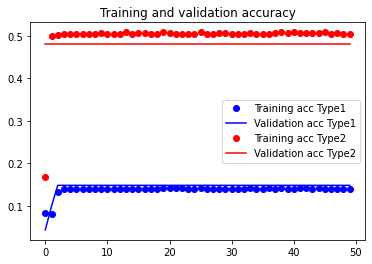

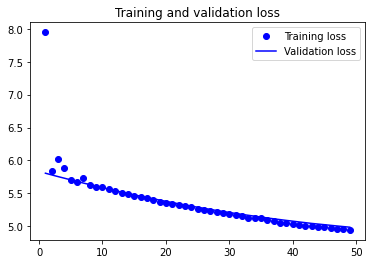

In [48]:
# Plot results

acc1 = H.history['type1_classification_accuracy']
acc2 = H.history['type2_classification_accuracy']
val_acc1 = H.history['val_type1_classification_accuracy']
val_acc2 = H.history['val_type2_classification_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc1))

plt.plot(epochs, acc1, 'bo', label='Training acc Type1')
plt.plot(epochs, val_acc1, 'b', label='Validation acc Type1')
plt.plot(epochs, acc2, 'ro', label='Training acc Type2')
plt.plot(epochs, val_acc2, 'r', label='Validation acc Type2')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("model14_1.png")
plt.figure()

plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("model14_2.png")
plt.show()


In [64]:
# Test model
MODEL_PATH='pokemon_model_14.h5'
TEST_IMAGE='images/images/squirtle.png'
FEATURES = np.load('features/pikachu.npy')

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
#plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Pikachu")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')



[INFO] loading network...
[INFO] classifying image...

 Pikachu

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%


In [64]:
# Test model
MODEL_PATH='pokemon_model_14.h5'
TEST_IMAGE='images/images/squirtle.png'
FEATURES = np.load('features/pikachu.npy')

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
#plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Pikachu")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')



[INFO] loading network...
[INFO] classifying image...

 Pikachu

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%


In [66]:
# Test model
MODEL_PATH='pokemon_model_14.h5'
FEATURES = np.load('features/pikachu.npy')
FEATURES1 = np.load('features/water.npy')
FEATURES2 = np.load('features/fire.npy')
FEATURES3 = np.load('features/test1.npy')

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Pikachu")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')

print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES1)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Squirtle")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')


print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES2)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Charmander")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')

print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES3)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Golem")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')




[INFO] classifying image...

 Pikachu

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%
[INFO] classifying image...

 Squirtle

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%
[INFO] classifying image...

 Charmander

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%
[INFO] classifying image...

 Golem

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%


In [16]:
def createHeadLayers(inputs):
    # setup params and where to save features
    
    # flatten the output convolutions, some implementations also 
    #. perform an average pooling here to collapse the features down
    x = Flatten()(inputs)
    # add two fully connected layers and some dropout
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid', name="type_classification")(x)
    
    return x

In [17]:
def createMultiTaskModel(inputShape, tasks):
    
    # construct both heads
    inputs = Input(shape=inputShape)
    output_grass = createHeadLayers(inputs)
    
    model = Model(
            inputs=inputs,
            outputs= [output_grass],
            name="pokemon")
        
    return model

In [36]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 20

# Load bottleneck features training
train_data = np.load('features/train.npy')

# Load bottleneck features validation
validation_data = np.load('features/validation.npy')

tasks = ['Poison']

train_labels = label_dataset(tasks[0], 'pokemon_2.csv')
print(train_labels)
inputs = Input(shape=input_shape[1:])
output = createHeadLayers(inputs)

data = load_images('images\images', [150, 150])
data = np.array(data, dtype='float')/255.0

# Extracting labels
ptypeLabels = label_dataset('Grass', 'pokemon_2.csv')

# binarize labels


split = train_test_split(data, ptypeLabels, test_size=0.2)
(trainX, testX, trainTypeY, testTypeY) = split


model = Model(
            inputs=inputs,
            outputs= output,
            name="pokemon")



model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])



history = model.fit(train_data, train_labels,
              epochs=EPOCHS,
              batch_size=BS,
              verbose=1)

model.save('pokemon_model.h5', save_format="h5")

Processed 809 lines.
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0

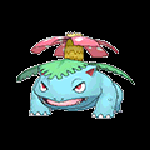

[[1.]]


In [54]:
from tensorflow.keras.preprocessing import image

img = image.load_img('images/images/venusaur.png', target_size = (150, 150))
display(img)
img = np.expand_dims(img, axis=0)



model = load_model('pokemon_model.h5')

x = base_model.predict(img)
result = model.predict(x)

print(result)
                     

In [21]:
# Plot training and validation accuracy

def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
plot_training_validation_acc(history)

KeyError: 'acc'